In [1]:
from pathlib import Path

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from timeit import default_timer as timer

import itertools

### Chargement des données

In [2]:
df = pd.read_csv(Path("V2_Plant_Seedlings_DataFrame.csv"))
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,sharpness_score,image_size,square
0,Input\Maize\196.png,Maize,196.png,1260,1260,96.623133,95.263001,68.305443,86.730526,371.683979,1587600,square
1,Input\Cleavers\33.png,Cleavers,33.png,352,352,80.315397,70.118769,50.518635,66.984267,39.836262,123904,square
2,Input\Charlock\454.png,Charlock,454.png,990,990,80.529463,75.808330,55.868748,70.735514,305.574312,980100,square
3,Input\Small-flowered Cranesbill\5.png,Small-flowered Cranesbill,5.png,162,162,80.199131,71.348765,45.413733,65.653876,9.546821,26244,square
4,Input\Small-flowered Cranesbill\91.png,Small-flowered Cranesbill,91.png,323,323,83.221012,71.454773,45.279941,66.651909,31.808805,104329,square


### Séparation des jeux d'entraînement et de test

In [3]:
# Train/test split: 80% dans le jeu train, 20% dans le jeu test
train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])


### Pre-processing

In [5]:
# Paramètres de pre-processing

rescale_factor = 1./255.
color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [6]:
# Instanciation du générateur de données

# Générateur des données d'entraînement: avec augmentation "forte" des données
train_data_generator = ImageDataGenerator(rescale=rescale_factor,
                                          shear_range=0.3,
                                          rotation_range=90,
                                          width_shift_range=0.3, 
                                          height_shift_range=0.3,
                                          zoom_range=0.4,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2)  # 20% du jeu train réservés pour évaluer le modèle au cours de l'entraînement

# Générateur des données de test: sans augmentation de données
test_data_generator = ImageDataGenerator(rescale=rescale_factor)


In [7]:
# Instanciation des itérateurs associés aux trois jeux train, validation et test

train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                          x_col='filepath',
                                                          y_col='species',
                                                          target_size=target_size,
                                                          color_mode=color_mode,
                                                          class_mode='sparse',
                                                          batch_size=batch_size,
                                                          subset="training")
validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = train_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


In [8]:
# Dictionnaire permettant de retrouver les classes à partir des labels
label2class = {x : y for y, x in train_iterator.class_indices.items()}
label2class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: "Shepherd's Purse",
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

### Construction du modèle

In [9]:
# Implémentation d'une architecture LeNet: construction séquentielle

model = Sequential()
model.add(Conv2D(filters=30,
                 kernel_size=(5,5),
                 activation='relu',
                 padding='valid',
                 input_shape=(target_size[0],target_size[1],channels)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=12,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 30)      2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 16)        0         
                                                                 
 flatten (Flatten)           (None, 46656)             0

In [11]:
# Compilation
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

### Définition des callbacks

In [13]:
checkpoint_filepath = Path('Model_checkpoint','best_weights.ckpt')
csvlogger_filepath = Path('training_history.csv')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=10,
                                         verbose=1)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
# Callback pour l'enregistrement de l'historique d'entraînement
csv_logger = CSVLogger(csvlogger_filepath,append=True)

# Callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

### Entraînement du modèle

In [12]:
nb_epochs = 120
training_history = model.fit(train_iterator,validation_data=validation_iterator,
                             epochs=nb_epochs,
                             steps_per_epoch=train_iterator.samples//batch_size,
                             validation_steps=validation_iterator.samples//batch_size,
                             callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                             verbose=True)

Epoch 1/120
110/110 [==============================] - ETA: 0s - loss: 2.4596 - accuracy: 0.1543
Epoch 1: val_accuracy improved from -inf to 0.17940, saving model to lenet_strongaugm_nosegmentation\best_weights.ckpt
110/110 [==============================] - 106s 956ms/step - loss: 2.4596 - accuracy: 0.1543 - val_loss: 2.3235 - val_accuracy: 0.1794 - lr: 0.0010
Epoch 2/120
110/110 [==============================] - ETA: 0s - loss: 2.1405 - accuracy: 0.2573
Epoch 2: val_accuracy improved from 0.17940 to 0.28704, saving model to lenet_strongaugm_nosegmentation\best_weights.ckpt
110/110 [==============================] - 108s 983ms/step - loss: 2.1405 - accuracy: 0.2573 - val_loss: 2.0187 - val_accuracy: 0.2870 - lr: 0.0010
Epoch 3/120
110/110 [==============================] - ETA: 0s - loss: 1.9418 - accuracy: 0.2926
Epoch 3: val_accuracy improved from 0.28704 to 0.33333, saving model to lenet_strongaugm_nosegmentation\best_weights.ckpt
110/110 [==============================] - 110s 1s

Epoch 26/120
110/110 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.6151
Epoch 26: val_accuracy did not improve from 0.63657
110/110 [==============================] - 99s 901ms/step - loss: 1.0671 - accuracy: 0.6151 - val_loss: 1.0529 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 27/120
110/110 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.6075
Epoch 27: val_accuracy did not improve from 0.63657
110/110 [==============================] - 99s 898ms/step - loss: 1.0719 - accuracy: 0.6075 - val_loss: 1.0196 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 28/120
110/110 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.6191
Epoch 28: val_accuracy did not improve from 0.63657
110/110 [==============================] - 97s 881ms/step - loss: 1.0536 - accuracy: 0.6191 - val_loss: 1.0126 - val_accuracy: 0.6134 - lr: 0.0010
Epoch 29/120
110/110 [==============================] - ETA: 0s - loss: 1.0397 - accuracy: 0.6063
Epoch 29: v

110/110 [==============================] - 97s 880ms/step - loss: 0.8498 - accuracy: 0.6892 - val_loss: 0.8561 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 52/120
110/110 [==============================] - ETA: 0s - loss: 0.8280 - accuracy: 0.7005
Epoch 52: val_accuracy improved from 0.71644 to 0.72685, saving model to lenet_strongaugm_nosegmentation\best_weights.ckpt
110/110 [==============================] - 99s 895ms/step - loss: 0.8280 - accuracy: 0.7005 - val_loss: 0.7580 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 53/120
110/110 [==============================] - ETA: 0s - loss: 0.8439 - accuracy: 0.6966
Epoch 53: val_accuracy did not improve from 0.72685
110/110 [==============================] - 98s 894ms/step - loss: 0.8439 - accuracy: 0.6966 - val_loss: 0.8551 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 54/120
110/110 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.7025
Epoch 54: val_accuracy did not improve from 0.72685
110/110 [=============================

110/110 [==============================] - 101s 923ms/step - loss: 0.6403 - accuracy: 0.7674 - val_loss: 0.6600 - val_accuracy: 0.7755 - lr: 5.0000e-04
Epoch 78/120
110/110 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7640
Epoch 78: val_accuracy did not improve from 0.77546
110/110 [==============================] - 113s 1s/step - loss: 0.6575 - accuracy: 0.7640 - val_loss: 0.6553 - val_accuracy: 0.7558 - lr: 5.0000e-04
Epoch 79/120
110/110 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.7612
Epoch 79: val_accuracy did not improve from 0.77546
110/110 [==============================] - 110s 1s/step - loss: 0.6561 - accuracy: 0.7612 - val_loss: 0.6485 - val_accuracy: 0.7708 - lr: 5.0000e-04
Epoch 80/120
110/110 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.7706
Epoch 80: val_accuracy did not improve from 0.77546
110/110 [==============================] - 109s 989ms/step - loss: 0.6190 - accuracy: 0.7706 - val_l

In [13]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 208.0 minutes.


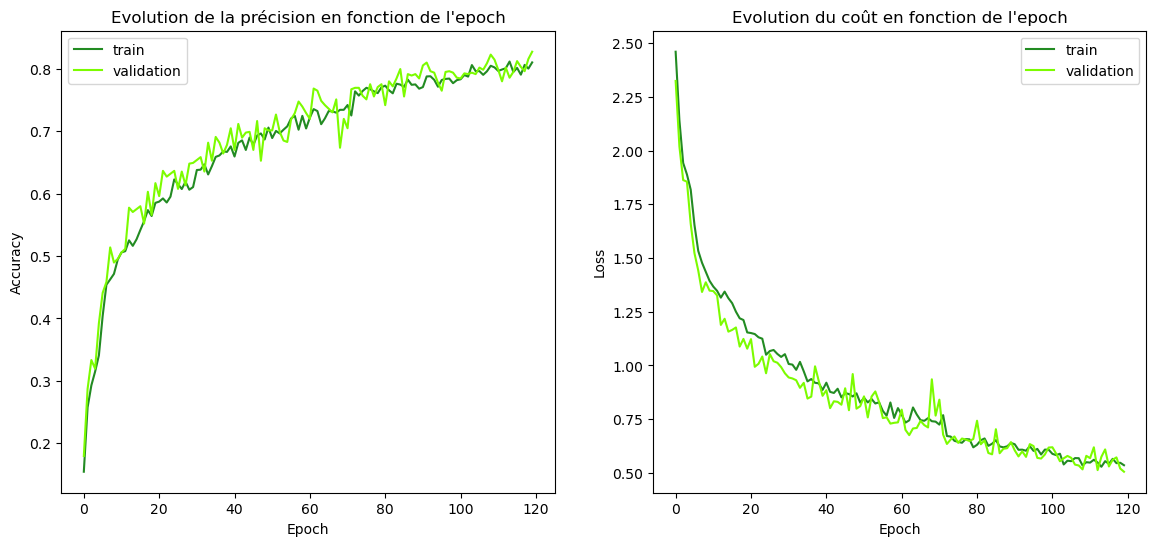

In [14]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement

def plot_history():
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');
    
plot_history()

### Sauvegarde du modèle final avec les meilleurs poids

In [14]:
# Chargement des meilleurs poids obtenus
model.load_weights(checkpoint_filepath)

In [16]:
# Sauvegarde au format TensorFlow SavedModel
saving_filepath = Path('Final_model')
model.save(saving_filepath)

INFO:tensorflow:Assets written to: lenet_strongaugm_nosegmentation\Final_model\assets


INFO:tensorflow:Assets written to: lenet_strongaugm_nosegmentation\Final_model\assets


### Evaluation du modèle

In [ ]:
# Chargement du modèle final
model = load_model(saving_filepath)

In [15]:
# Evaluation sur les jeux train, validation et test
res = pd.DataFrame(index=['train','validation','test'],columns=['loss','accuracy'])
res.iloc[0,:] = model.evaluate(train_iterator)
res.iloc[1,:] = model.evaluate(validation_iterator)
res.iloc[2,:] = model.evaluate(test_iterator)

# Sauvegarde dans un fichier CSV
res.to_csv('lenet_strongaugm_nosegmentation_results.csv')

35/35 [==============================] - 27s 769ms/step - loss: 0.5431 - accuracy: 0.8132


In [17]:
# Affichage des résultats
res

,loss,accuracy
train,0.513262,0.816079
validation,0.548124,0.820542
test,0.54306,0.813177


35/35 [==============================] - 17s 477ms/step
                           precision    recall  f1-score   support

              Black-grass       0.59      0.32      0.42        62
                 Charlock       0.84      0.84      0.84        90
                 Cleavers       0.82      0.84      0.83        67
         Common Chickweed       0.91      0.90      0.91       143
             Common wheat       0.84      0.90      0.87        51
                  Fat Hen       0.82      0.83      0.83       108
         Loose Silky-bent       0.76      0.87      0.81       152
                    Maize       0.87      0.78      0.82        51
        Scentless Mayweed       0.78      0.93      0.85       121
         Shepherd's Purse       0.71      0.58      0.64        55
Small-flowered Cranesbill       0.86      0.86      0.86       115
               Sugar beet       0.80      0.75      0.78        93

                 accuracy                           0.81      1108
    

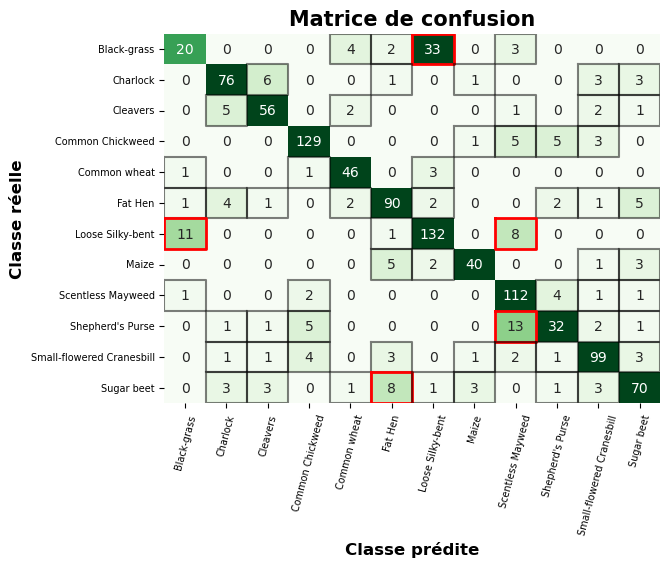

In [30]:
# Rapport de classification & matrice de confusion

def show_metrics():
    y_true = test_iterator.classes
    y_pred = model.predict(test_iterator).argmax(axis=-1)

    print(classification_report(y_true, y_pred, target_names = test_iterator.class_indices.keys()))
    
    matrix = confusion_matrix(y_true, y_pred)
    classes = test_iterator.class_indices.keys()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);

show_metrics()